In [44]:
import os
from rosemary import jpt_in_notebook, jpt_setup; jpt_setup()
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm
import numpy as np

log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'
nodes = 1; gpus=6
use_lora = False
text_pooling_type = 'meanpool'
grad_randproj_components = 2048
save_grad_embeddings = False
torch_dtype = 'float16'
add_rsum = False

test_run = 1
test_run = bool(test_run)

#### auto-regressive model, compute loss/embedding/grad
model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'; max_seq_len = 2048
# model_name = 'llama2-7b'; model_name_or_path = '../results/baselines/NousResearch/Llama-2-7b-hf'; max_seq_len = 2048
# model_name = 'llama-7b_ft=hmv1'; model_name_or_path = '../results/ft1/llama-7b_humanmix'; max_seq_len = 2048
# model_name = 'pythia-1b'; model_name_or_path = '../results/baselines/EleutherAI/pythia-1b-deduped'; max_seq_len = 2048
# model_name = 'pythia-160m'; model_name_or_path = '../results/baselines/EleutherAI/pythia-160m-deduped'; max_seq_len = 2048; torch_dtype = 'float32'
# model_name = 'pythia-410m'; model_name_or_path = '../results/baselines/EleutherAI/pythia-410m-deduped'; max_seq_len = 2048
# model_name = 'mistral-7b'; model_name_or_path = '../results/baselines/mistralai/Mistral-7B-v0.1'; max_seq_len = 2048
# model_name = 'mistral-7b+ultrachat200kv1'; model_name_or_path = '../results/ft1_ep=2/mistral-7b_ultrachat200k_beforesplitlongconv'; max_seq_len = 2048
# model_name = 'llama-7b+lima'; model_name_or_path = '../results/oi2/llama-7b_lima_ep=5'; max_seq_len = 2048
# model_name = 'codellama-7b'; model_name_or_path = '../results/baselines/codellama/CodeLlama-7b-hf'; max_seq_len = 2048

compute_loss = True; compute_grad = True; encode_fn_type = 'sft' # 'sft'
use_lora = True;  lora_rank = 512; lora_alpha = int(np.sqrt(lora_rank)**3); grad_randproj_components = 4096
# use_lora = True;  lora_rank = 256; lora_alpha = int(np.sqrt(lora_rank)**3); grad_randproj_components = 4096

## test different projection schemes.
# use_lora = False; grad_randproj_components = 4096; add_rsum = False; save_grad_embeddings = True
# use_lora = True; lora_rank = 512; lora_alpha = int(np.sqrt(lora_rank)**3); grad_randproj_components = 4096; add_rsum = True; save_grad_embeddings = True
####

# ####
# # encoder-based model, for computing embedding only
# model_name = 'all-mpnet-base-v2'; model_name_or_path = '../results/baselines/sentence-transformers/all-mpnet-base-v2'; max_seq_len = 512; text_pooling_type = 'meanpool'
# # model_name = 'bge-large-en-v1.5'; model_name_or_path = '../results/baselines/BAAI/bge-large-en-v1.5'; max_seq_len = 128; text_pooling_type = 'cls'

# compute_loss = False; compute_grad = False; encode_fn_type = 'input'
# #####

##### 

## pretty time consuming 
# datasets = ['open_orca_slim']; nodes=10; gpus=6; cpu_mem=512
datasets = ['tulu_v2']; nodes=20; gpu=6; cpu_mem=512
# datasets = ['sharegptv2']; nodes=7; gpus=6; cpu_mem=512
# datasets = ['ultrachat200kv2']; nodes=7; gpus=6; cpu_mem=512


## manageable
# datasets = ['stanford_alpaca']; nodes=5; gpu=6; cpu_mem=512
# datasets = ['wizardlmv2']; nodes=5; gpus=6; cpu_mem=512
# datasets = ['flan_v2']; nodes=2; gpu=6; cpu_mem=512
# datasets = ['oasst1']; nodes=1; gpu=6; cpu_mem=512
# datasets = ['dolly']; nodes=1; gpu=6; cpu_mem=512
# datasets = ['lima']; nodes=1; gpu=6; cpu_mem=512
# datasets = [
#     'gpt4_alpaca',
#     'self_instruct',
#     'unnatural_instructions',
# ]; nodes=5; gpu=6; cpu_mem=512

#####
# tulu_v1_mix:
# datasets = ['flan_v2', 'cot', 'dolly', 'oasst1', 'gpt4_alpaca', 'code_alpaca', 'sharegpt']; nodes = 5; gpu=6; cpu_mem = 512
# datasets = ['tulu_v1_human_mix', 'tulu_v1_mix']; nodes = 1; gpus=1; cpu_mem = 64
# tulu_v2_mix:
# datasets = ['tulu_v2']; nodes=1; gpus=1; cpu_mem=512
# datasets = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1', 'gpt4_alpaca', 'code_alpaca']; nodes = 3; gpus=6; cpu_mem = 512
# datasets = ['wizardlm']; nodes = 3; gpus=6; cpu_mem=512
# datasets = ['sharegpt', 'ultrachat']; nodes = 5; gpus=6; cpu_mem = 512
# datasets = ['ultrachat15']; nodes = 3; gpus=6; cpu_mem = 512
# datasets = [f'ultrachat15_{i}' for i in [0, 2]]; nodes = 5; gpus=6; cpu_mem = 512
# datasets = ['starcoder_commentinstr_cleaned',
#             'starcoder_commentinstr',]; nodes=1; gpus=6; cpu_mem=512
# datasets = [
#     'starcoder_commentinstrv2', # cleaned version
# #     'starcoder_commentinstrv3',
# ]; nodes = 3; gpus = 6; cpu_mem=512

# datasets = ['starcoder_commentinstrv5']; nodes = 3; gpus = 6; cpu_mem=512

# datasets = ['tulu_v2_human_mix', 'tulu_v2_mix']; nodes = 1; gpus=1; cpu_mem = 64
# datasets = ['flan_v2']; nodes = 1; gpus=6; cpu_mem = 512
# datasets = ['flan2022_1m']; nodes = 5; gpus=6; cpu_mem = 512 # if not compute grad embeddings
# datasets = ['flan2022_1m']; nodes = 15; gpus=6; cpu_mem = 512 # if do compute grad embeddings
# datasets = ['flan2022v2_1m']; nodes = 5; gpus=6; cpu_mem = 512

# # # for testing
# datasets = ['lima']; nodes = 1; gpus=6; cpu_mem = 512

save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
            f"model_outputs/{encode_fn_type}/{model_name}")
if use_lora:
    save_dir += f'+lora:r={lora_rank}:a={lora_alpha}'
if encode_fn_type != 'input':
    save_dir += f'+proj={grad_randproj_components}'

use_dist = True if nodes*gpus>1 else False
for dataset in datasets:
    
    if use_dist:
        prefix = f"""
    torchrun --nnodes={nodes} --nproc_per_node={gpus} \
        --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT \
        """
    else:
        prefix = 'python'
    
    cmd = f"""
        {prefix}
        note_llama_embeddings.py \
        --dataset={dataset} \
        --model_name_or_path={model_name_or_path} \
        {'--use_dist' if use_dist else ''} \
        --shuffle \
        {'--compute_loss' if compute_loss else ''} \
        {'--compute_grad' if compute_grad else ''} \
        {'--use_lora' if use_lora else ''} \
        {'--lora_rank='+str(lora_rank) if use_lora else ''} \
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''} \
        --compute_grad_embeddings \
        {'--save_grad_embeddings' if save_grad_embeddings else ''} \
        --grad_randproj_components {grad_randproj_components} \
        --max_seq_len={max_seq_len} \
        --encode_fn_type={encode_fn_type} \
        --text_pooling_type={text_pooling_type} \
        {'--add_rsum' if add_rsum else ''} \
        --torch_dtype={torch_dtype} \
        --save_dir={save_dir} \
    """
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'lm_outputs.{dataset}', 
        nodes=nodes,
        num_cpus=32,
        cpu_mem=cpu_mem,
        num_gpus=gpus,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    if not test_run:
        print(out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Submiting job with:
{
    "job_name": "lm_outputs.tulu_v2",
    "nodes": 20,
    "num_cpus": 32,
    "cpu_mem": 512,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
torchrun --nnodes=20 --nproc_per_node=6 --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT note_llama_embeddings.py --dataset=tulu_v2 --model_name_or_path=../results/baselines/huggyllama/llama-7b --use_dist --shuffle --compute_loss --compute_grad --use_lora --lora_rank=512 --lora_alpha=11585 --compute_grad_embeddings --grad_randproj_components 4096 --max_seq_len=2048 --encode_fn_type=sft --text_pooling_type=meanpool --torch_dtype=float16 --save_dir=/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/sft/llama-7b+lora:r=512:a=11585+proj=4096
[{'args': 'sbatch --job-name=lm_outputs.tulu_v2 --partition=el8 --nodes=20 --ntasks-per-node=1 --cpus-per-task=32 --mem=512GB --gres=gpu:6 --output=/gpfs/u/scr

In [7]:
from note_pruning_analysis import get_dataset
ds = get_dataset('oasst1')
ds

Found cached dataset json (/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed/oasst1/json/default-7a3a4cd7ac543b88/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


Dataset({
    features: ['dataset', 'id', 'messages'],
    num_rows: 33717
})

In [8]:
!CUDA_VISIBLE_DEVICES=4 python note_llama_embeddings.py --dataset=open_orca_slim --model_name_or_path=../results/baselines/NousResearch/Llama-2-7b-hf --shuffle --compute_loss --compute_grad --use_lora --lora_rank=256 --lora_alpha=256 --compute_grad_embeddings --grad_randproj_components 2048 --max_seq_len=2048 --encode_fn_type=output --text_pooling_type=meanpool --save_dir=/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/output/llama2-7b+lora:r=256:a=256


[2023-12-14 23:25:33,239] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)
rank/local_rank/world_size: 0/0/1

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:03<00:00,  1.76s/it]
/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/open-instruct/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in 


KeyboardInterrupt



In [2]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()


if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1,4
4
Sun Dec 31 01:08:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   32C    P0    67W / 300W |   5563MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| 

In [3]:
from collections import defaultdict
from functools import partial
import os
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 
import pandas as pd
from sklearn.random_projection import SparseRandomProjection


import pyarrow # import before `torch`, `transformers`, `datasets`
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

from open_instruct.finetune_trainer import encode_with_prompt_completion_format, encode_with_messages_format
from note_llama_embeddings import (
    encode_just_one_role,
    sklearn_rp_mat_size,
    combine_lm_outputs_for_mixes, 
    datasets_shard_chunk_size, 
    compute_losses, 
    compute_grad_statistic, 
    compute_grad_norm,
    gather_grad_embeddings,
    print_trainable_parameters,
    get_grad_statistic_pattern,
)



[2023-12-31 01:08:21,642] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
test_run = True

save_grad_embeddings = False
dataset = 'flan_v2'
dataset = 'oasst1'
dataset = 'tulu_v1_mix'
dataset = 'lima'
dataset = 'ultrachat15_0'
dataset = 'wizardlm'
dataset = 'stanford_alpaca'
dataset = 'lima'; save_grad_embeddings = True

use_dist = False
shuffle = True
lora_rank = 256
lora_alpha = lora_rank
# lora_alpha = int(np.sqrt(lora_rank))
lora_alpha = int(np.sqrt(lora_rank)**3)
grad_randproj_components = 2048
encode_fn_type = 'input'  # input, output, sft
encode_fn_type = 'output'
max_seq_len = 2048
text_pooling_type = 'meanpool'
add_rsum = False
# add_rsum = True
torch_dtype = 'float32' # 'float16'

#####
# model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'
# model_name = 'pythia-1b-deduped'; model_name_or_path = 'EleutherAI/pythia-1b-deduped'
model_name = 'pythia-160m-deduped'; model_name_or_path = '../results/baselines/EleutherAI/pythia-160m-deduped'
# model_name = 'pythia-410m-deduped'; model_name_or_path = '../results/baselines/EleutherAI/pythia-410m-deduped'
# model_name = 'mistral-7b'; model_name_or_path = '../results/baselines/mistralai/Mistral-7B-v0.1'
compute_grad_embeddings = True; use_lora = True; compute_grad=True; compute_loss = True
# compute_grad_embeddings = True; use_lora = False; compute_grad=True; compute_loss = True
#####

# #####
# model_name = 'all-mpnet-base-v2'; model_name_or_path = '../results/baselines/sentence-transformers/all-mpnet-base-v2'
# compute_grad_embeddings = False; use_lora = False; compute_grad = False; compute_loss = False
# #####


save_dir = f"model_outputs/{encode_fn_type}/{model_name}"
if not test_run:
    os.makedirs(save_dir, exist_ok=True)
    
print(save_dir)

model_outputs/output/pythia-160m-deduped


In [5]:
if dataset in ['tulu_v1_human_mix', 
               'tulu_v1_mix',
               'tulu_v2_human_mix',
               'tulu_v2_mix']:
    combine_lm_outputs_for_mixes(dataset, save_dir)

if use_dist:
    dist.init_process_group("gloo", timeout=datetime.timedelta(hours=6))
    world_size = dist.get_world_size()
    rank = dist.get_rank() # global rank
    local_rank = int(os.environ["LOCAL_RANK"])
else:
    rank = 0
    local_rank = 0
    world_size = 1

print(f'rank/local_rank/world_size: {rank}/{local_rank}/{world_size}\n')

device = f'cuda:{str(local_rank)}'

rank/local_rank/world_size: 0/0/1



In [6]:
if 'sentence-transformers' in model_name_or_path:
    from transformers import AutoModel
    model = AutoModel.from_pretrained(
        model_name_or_path,
        device_map=device)
else:
    model = AutoModelForCausalLM.from_pretrained(
        model_name_or_path,
        device_map=device,
        torch_dtype=getattr(torch, torch_dtype),
    )
    

In [7]:
if use_lora:
    if not compute_grad:
        raise ValueError('compute_grad must be True if use LoRA!')
    
    print(f'Initializing lora(r={lora_rank},a={lora_alpha})')
    # ensure the same initialization
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    
    if any(x in model_name_or_path.lower() for x in ['llama', 'mistral']):
        # # the following also applies lora to MLP layers.
        # target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
        target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj']
    elif 'pythia' in model_name_or_path:
        target_modules = ['query_key_value']
    else:
        raise ValueError(f'Define new `target_modules` for LoraConfig for {model_name_or_path}')

    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, 
        inference_mode=False, 
        bias='none',
        r=lora_rank,
        lora_alpha=lora_alpha, 
        lora_dropout=0.,
        target_modules=target_modules,
        init_lora_weights='gaussian',
    )
    
    model.enable_input_require_grads()
    model = get_peft_model(model, peft_config)
    
    ## don't need to compute gradient to `lora_A`, saves computation (i think) but not space.
    for param_name, param in model.named_parameters():
        if param.requires_grad and 'lora_A' in param_name:
            param.requires_grad = False

print_trainable_parameters(model)

Initializing lora(r=256,a=4096)
trainable params: 7077888 || all params: 171760128 || trainable%: 4.12


In [8]:
if compute_grad:
    if any(x in model_name_or_path.lower() for x in ['llama', 'mistral']):
        # Computing full gradient for llama is computationally prohibitive.
        # Use gradient checkpointing to prevent oom issues.
        # Note gradient checkpointing is only applied when in training mode
        #     https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L908
        # So need to set `model.train()`. This is harmless because
        # llama's eval/train computation is exactly the same, since there's no dropout layer.
        model.gradient_checkpointing_enable()
        model.train()
else:
    model.eval()

In [9]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [10]:

processed_dir = '../data/processed'
if 'flan2022' in dataset:
    train_file = os.path.join(processed_dir, 'flan2022', f'{dataset}_data.jsonl')
elif 'ultrachat' in dataset:
    train_file = os.path.join(processed_dir, 'ultrachat', f'{dataset}_data.jsonl')
elif 'open_orca' in dataset:
    train_file = os.path.join(processed_dir, 'open_orca', f'{dataset}_data.jsonl')
elif 'sharegpt' in dataset:
    train_file = os.path.join(processed_dir, 'sharegpt', f'{dataset}_data.jsonl')
elif 'starcoder' in dataset:
    train_file = os.path.join(processed_dir, 'starcoder', f'{dataset}.jsonl')
else:
    train_file = os.path.join(processed_dir, dataset, f'{dataset}_data.jsonl')
assert(os.path.isfile(train_file))

if encode_fn_type in ['input', 'output']:
    encode_function = partial(
        encode_just_one_role,
        tokenizer=tokenizer,
        max_seq_length=max_seq_len,
        encode_fn_type=encode_fn_type,
        # add eos token to causal models, e.g., llama, since its not added by default.
        add_eos_token=False if any(y in model_name_or_path for y in ['mpnet', 'bge']) else True,
    )
elif encode_fn_type == 'sft':    
    encode_function = partial(
        encode_with_messages_format,
        tokenizer=tokenizer,
        max_seq_length=max_seq_len,
        add_eos_token=False,
    )
else:
    raise ValueError(f'encode_fn_type={encode_fn_type} not implemented.')

In [11]:
if rank == 0:
    raw_datasets = load_dataset("json", data_files={'train': train_file})
    if test_run:
        raw_datasets['train'] = raw_datasets['train'].select(range(1000))
    # print(f"{dataset} dataset length = {len(raw_datasets['train'])}")
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")
if use_dist:
    dist.barrier()
if rank!= 0:
    raw_datasets = load_dataset("json", data_files={'train': train_file})
    if test_run:
        raw_datasets['train'] = raw_datasets['train'].select(range(1000))
    # print(f"{dataset} dataset length = {len(raw_datasets['train'])}")
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")

train_dataset = lm_datasets['train']
train_dataset.set_format(
    type="torch",
    output_all_columns=False,
    columns=['input_ids', 'labels', 'attention_mask'])
if shuffle:
    random.seed(0)
    shuffle_inds = list(range(len(train_dataset)))
    random.shuffle(shuffle_inds)
    reverse_shuffle_inds = [(i, ind) for i, ind in enumerate(shuffle_inds)]
    reverse_shuffle_inds = sorted(reverse_shuffle_inds, key=lambda x: x[1])
    reverse_shuffle_inds = [x[0] for x in reverse_shuffle_inds]
    train_dataset = train_dataset.select(shuffle_inds)
train_dataset_chunk_sizes = [datasets_shard_chunk_size(len(train_dataset), num_shards=world_size, index=i) 
            for i in range(world_size)]
train_dataset = train_dataset.shard(
    num_shards=world_size, 
    index=rank,
    contiguous=True)
loader = DataLoader(train_dataset, shuffle=False, batch_size=1, pin_memory=True) 

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-1ca1bac0eed76345/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-1ca1bac0eed76345/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-8cf7c07d1f39f309_*_of_00016.arrow


In [12]:

grad_statistic_patterns = get_grad_statistic_pattern(model_name_or_path, use_lora)
grad_statistic_patterns


{'loraB': 'lora_B\\.[a-zA-Z_]+\\.weight'}

In [13]:
from note_llama_embeddings import mean_pooling

if compute_grad_embeddings:
    rps = {}
    for k in grad_statistic_patterns.keys():
        rps[k] = SparseRandomProjection(n_components=grad_randproj_components, random_state=0)

output = defaultdict(list)
for i, batch in tqdm(enumerate(loader), disable=rank!=0, total=len(loader)):
    batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
    
    if compute_grad:
        outputs = model(**batch, output_hidden_states=True, use_cache=False)
        model.zero_grad()
        outputs['loss'].backward()
    else:
        with torch.inference_mode():
            outputs = model(**batch, output_hidden_states=True)
    
    # (bsz, seq_len, hidden_size) -> (bsz, hidden_size)
    last_hidden_state = outputs['hidden_states'][-1]
    if text_pooling_type == 'meanpool':
        text_embedding = mean_pooling(last_hidden_state, batch['attention_mask'])
    elif text_pooling_type == 'cls':
        text_embedding = last_hidden_state[:, 0]
    else:
        raise ValueError(f'text_pooling_type={text_pooling_type} not supported.')
    output['text_embedding'].append(text_embedding.to(torch.float32).detach().cpu())

    if compute_loss:
        # average of output token log probs
        if 'loss' in outputs:
            output['log_prob'].append(-outputs['loss'].detach().cpu())

        # el2n scores
        losses = compute_losses(outputs['logits'], batch['labels'])
        for k in ['el2n_agg=mean', 'el2n_agg=l2n', 'logit_margin']:
            output[k].append(losses[k].detach().cpu())
            
    ## gradient statistic
    if compute_grad:
        grad_statistics = compute_grad_statistic(model, grad_statistic_patterns)
        for k, v in grad_statistics.items():
            output[f'grad_{k}'].append(v.detach().cpu())
            
        if compute_grad_embeddings:
            grad_embeddings = gather_grad_embeddings(
                model,
                {k: v for k, v in grad_statistic_patterns.items() if k in ['qkv', 'loraB']},
                stacked=True,
                add_rsum=add_rsum,
            )
            model.zero_grad(set_to_none=True)
            if save_grad_embeddings:
                for k, v in grad_embeddings.items():
                    output[f'grad_{k}'].append(v)
            if i==0:
                rps = {}
                for k, v in grad_embeddings.items():
                    t0 = time.time()
                    if 'rsum' not in k:
                        rps[k] = SparseRandomProjection(n_components=grad_randproj_components, random_state=0)
                    else:
                        rps[k] = GaussianRandomProjection(n_components=grad_randproj_components, random_state=0)
                    print(f"Fitting random projection for {k} ({v.size} -> {grad_randproj_components})")
                    rps[k] = rps[k].fit(v[np.newaxis,...])
                    print(f"Fitting random projection in {time.time() - t0:0.3f}s "
                        f"with random matrix size {sklearn_rp_mat_size(rps[k]) / 1e6:0.3f} MB")
                    print(f'Log statistics of projection matrix for {k} to ensure same initialization cross procs:\n'
                        f"{np.mean(rps[k].components_ != 0)}, {np.max(rps[k].components_)}, {np.mean(rps[k].components_[0])}")
            for k in grad_embeddings.keys():
                rp = rps[k]
                g = grad_embeddings[k]
                output[f'grad_rp_{k}'].append(rp.transform(g[np.newaxis,...]).squeeze())
    i += 1
    if i == 1:
        break


  0%|          | 0/1000 [00:00<?, ?it/s]

Fitting random projection for loraB (7077888 -> 2048)


  0%|          | 0/1000 [00:45<?, ?it/s]

Fitting random projection in 44.747s with random matrix size 43.618 MB
Log statistics of projection matrix for loraB to ensure same initialization cross procs:
0.0003761366975528307, 1.1397535800933838, 5.313996098266216e-06


In [36]:
Z_original = output['grad_rp_loraB'][0]
print(Z_original.shape)

(2048,)


In [32]:
g = grad_embeddings['loraB']
X = g[np.newaxis, ...]
print(X.shape)

(1, 7077888)


In [42]:
rp = rps['loraB']

rp.components_

<2048x7077888 sparse matrix of type '<class 'numpy.float32'>'
	with 5452295 stored elements in Compressed Sparse Row format>

In [40]:

Z = X @ rps['loraB'].components_.T

Z = Z.squeeze()
print(Z.shape)

(Z - Z_original)

  (0, 1337)	-1.1397536
  (0, 3466)	-1.1397536
  (0, 7208)	1.1397536
  (0, 7228)	1.1397536
  (0, 10738)	-1.1397536
  (0, 11908)	1.1397536
  (0, 13429)	-1.1397536
  (0, 14609)	1.1397536
  (0, 16371)	-1.1397536
  (0, 20737)	1.1397536
  (0, 23842)	-1.1397536
  (0, 26704)	1.1397536
  (0, 30105)	1.1397536
  (0, 32444)	1.1397536
  (0, 32884)	-1.1397536
  (0, 33979)	1.1397536
  (0, 35025)	-1.1397536
  (0, 37219)	1.1397536
  (0, 37708)	-1.1397536
  (0, 39492)	1.1397536
  (0, 39603)	1.1397536
  (0, 39965)	-1.1397536
  (0, 41470)	-1.1397536
  (0, 42441)	1.1397536
  (0, 42506)	1.1397536
  :	:
  (2047, 7006310)	-1.1397536
  (2047, 7008470)	-1.1397536
  (2047, 7010913)	-1.1397536
  (2047, 7013332)	1.1397536
  (2047, 7014674)	1.1397536
  (2047, 7019745)	1.1397536
  (2047, 7020097)	1.1397536
  (2047, 7027654)	1.1397536
  (2047, 7031843)	1.1397536
  (2047, 7037807)	-1.1397536
  (2047, 7039706)	1.1397536
  (2047, 7043143)	1.1397536
  (2047, 7043591)	-1.1397536
  (2047, 7046220)	-1.1397536
  (2047, 70464

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [125]:
# %timeit X @ rps['loraB'].components_.T


np.abs((X @ rps['loraB'].components_.T) - rp.transform(X)).mean()



4.0965685e-07

In [131]:
rps['loraB'].components_.data

array([-1.1397536, -1.1397536,  1.1397536, ..., -1.1397536, -1.1397536,
        1.1397536], dtype=float32)

In [130]:
a = X @ rps['loraB'].components_.T
b = rp.transform(X)


np.abs((a-b)/a).max()

0.0011366098

In [114]:

        
rp = TorchSparseRandomProjection(n_components=grad_randproj_components, random_state=0)
rp.fit(X)



TorchSparseRandomProjection(n_components=2048, random_state=0)

In [115]:
Z_new = rp.transform(X)


In [117]:
%timeit rp.transform(X)

11.5 ms ± 19.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
Z_new - Z_original

array([[-1.1920929e-07,  5.9604645e-07, -1.7881393e-07, ...,
         3.5762787e-07,  4.7683716e-07, -1.0728836e-06]], dtype=float32)

In [77]:

P = rp.components_.transpose().tocsr()

# print(P.indptr.shape, P.indices.shape, P.data.shape)


Pt = torch.sparse_csr_tensor(torch.from_numpy(P.indptr),
                                torch.from_numpy(P.indices),
                                torch.from_numpy(P.data))

torch.from_numpy(X) @ Pt




tensor([[-1.0194, -1.4528, -0.4346,  ..., -1.4696, -1.1844,  0.5285]])

<7077888x2048 sparse matrix of type '<class 'numpy.float32'>'
	with 5452295 stored elements in Compressed Sparse Column format>

In [18]:
for k, v in output.items():
    if isinstance(v, torch.Tensor):
        output[k] = torch.vstack(v).to(torch.float32).numpy()
    else:
        output[k] = np.vstack(v)


print(f'[local_rank/global={local_rank}/{rank}] '
      f'output={[(k, v.shape, v.dtype) for k, v in output.items()]}')

[local_rank/global=0/0] output=[('text_embedding', (1, 768), dtype('float32')), ('log_prob', (1, 1), dtype('float32')), ('el2n_agg=mean', (1, 1), dtype('float32')), ('el2n_agg=l2n', (1, 1), dtype('float32')), ('logit_margin', (1, 1), dtype('float32')), ('grad_loraB_l2n', (1, 1), dtype('float32')), ('grad_loraB', (1, 7077888), dtype('float32')), ('grad_rp_loraB', (1, 2048), dtype('float32'))]


In [6]:

from note_llama_embeddings import grad_vectors_compute_cdist, get_grad_vectors_cdist, plt_rates_std_vs_projected_dim
dataset = 'lima'
model_names = [
    'pythia-160m',
#     'pythia-160m+lora:r=256:a=4096',
    'pythia-160m+lora:r=512:a=11585',
#     'pythia-160m+lora:r=512:a=11585+proj=1024',
#     'pythia-160m+lora:r=512:a=11585+proj=4096',
#     'pythia-160m+lora:r=512:a=11585+proj=8192',
    'pythia-1b+lora:r=512:a=11585+proj=2048',
#     'pythia-1b+lora:r=512:a=11585+proj=4096',
]

# grad_vectors_compute_cdist(dataset, model_names)

Ds, df = get_grad_vectors_cdist(dataset, model_names, 
                                compute_dist_with_normalized_vector=False,
#                                 base_vector_name='grad_qkv',
                                base_vector_name='grad_loraB_r=512_p=_md=pythia-1b',
                               )
df

,name,shape,rates_mean,rates_std,base_model,lora_rank,lora_alpha,proj
0,grad_rp_qkv,"(1030, 2048)",0.999472,0.034009,None,NaN,NaN,2048
1,grad_loraB_r=512_a=11585_p=2048_md=pythia-160m,"(1030, 14155776)",1.002865,0.015333,pythia-160m,512.0,11585.0,2048
2,grad_loraBrsum_r=512_a=11585_p=2048_md=pythia-...,"(1030, 6144)",1.022627,0.146094,pythia-160m,512.0,11585.0,2048
3,grad_loraBrsumcyc_r=512_a=11585_p=2048_md=pyth...,"(1030, 6144)",1.003061,0.038467,pythia-160m,512.0,11585.0,2048
4,grad_rp_loraB_r=512_a=11585_p=2048_md=pythia-160m,"(1030, 2048)",0.997942,0.036726,pythia-160m,512.0,11585.0,2048
5,grad_rp_loraBrsum_r=512_a=11585_p=2048_md=pyth...,"(1030, 2048)",1.024144,0.147873,pythia-160m,512.0,11585.0,2048
6,grad_rp_loraBrsumcyc_r=512_a=11585_p=2048_md=p...,"(1030, 2048)",1.001702,0.042233,pythia-160m,512.0,11585.0,2048
7,grad_loraB_r=512_a=11585_p=2048_md=pythia-1b,"(1030, 50331648)",0.456016,0.334357,pythia-1b,512.0,11585.0,2048
8,grad_loraBrsum_r=512_a=11585_p=2048_md=pythia-1b,"(1030, 8192)",0.466882,0.354317,pythia-1b,512.0,11585.0,2048
9,grad_loraBrsumcyc_r=512_a=11585_p=2048_md=pyth...,"(1030, 8192)",0.455211,0.333213,pythia-1b,512.0,11585.0,2048


In [ ]:

title = f"{dataset}:{model_names[0]}"
fig, ax = plt_rates_std_vs_projected_dim(
    df[ df.base_model.isin(['pythia-160m']) | df.base_model.isna() ])
fig.suptitle(title)

Text(0.5, 0.98, 'lima:pythia-1b')

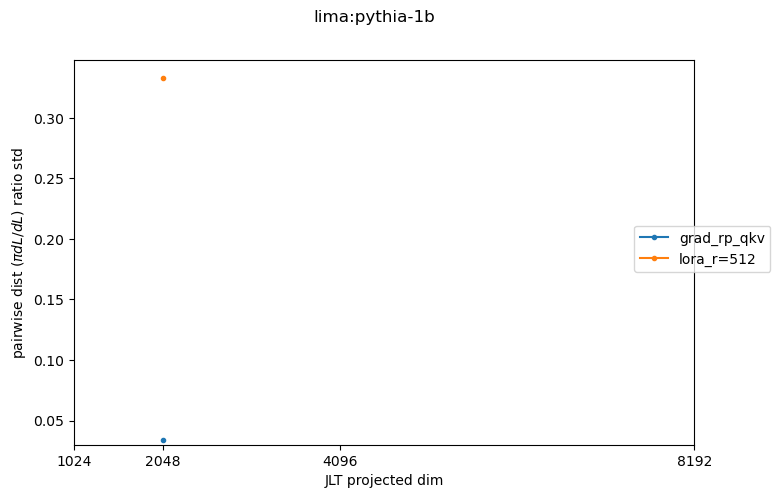

In [7]:
title = f"{dataset}:pythia-1b"
fig, ax = plt_rates_std_vs_projected_dim(
    df[ df.base_model.isin(['pythia-1b']) | df.base_model.isna() ])
fig.suptitle(title)

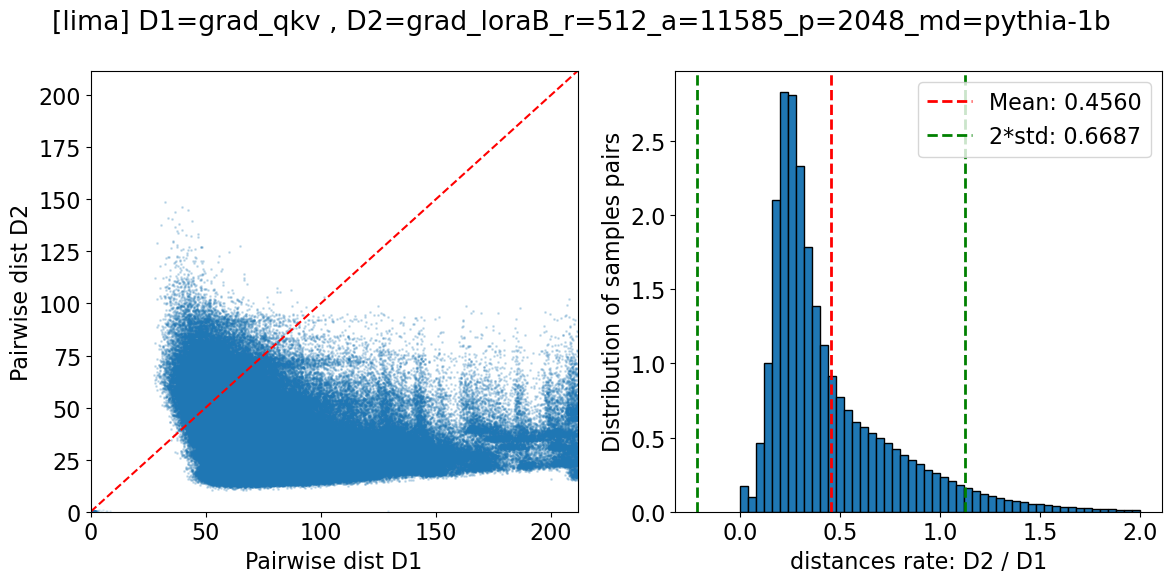

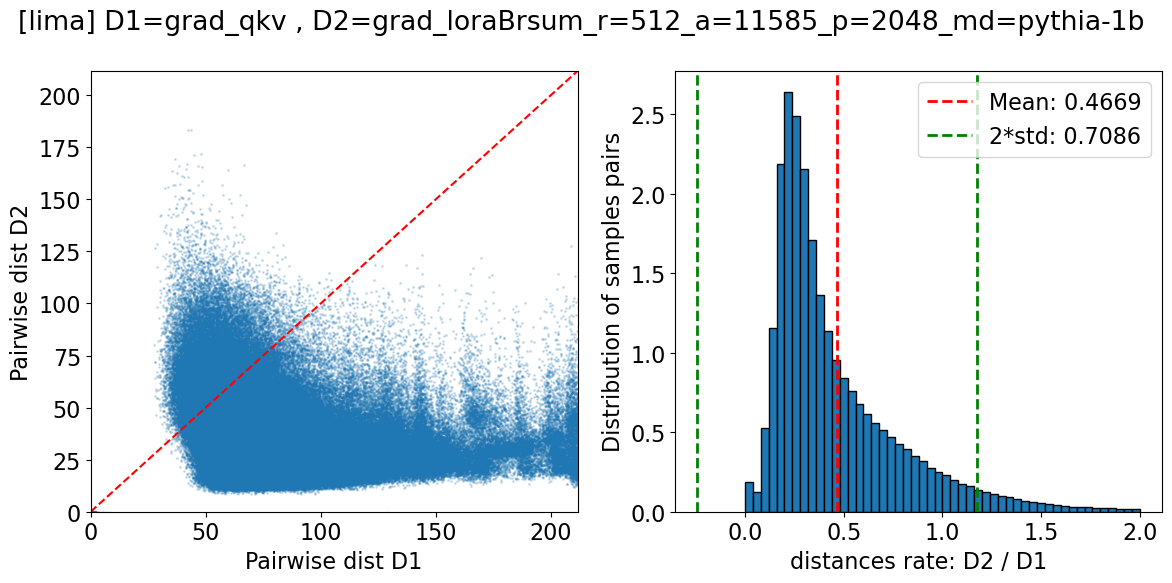

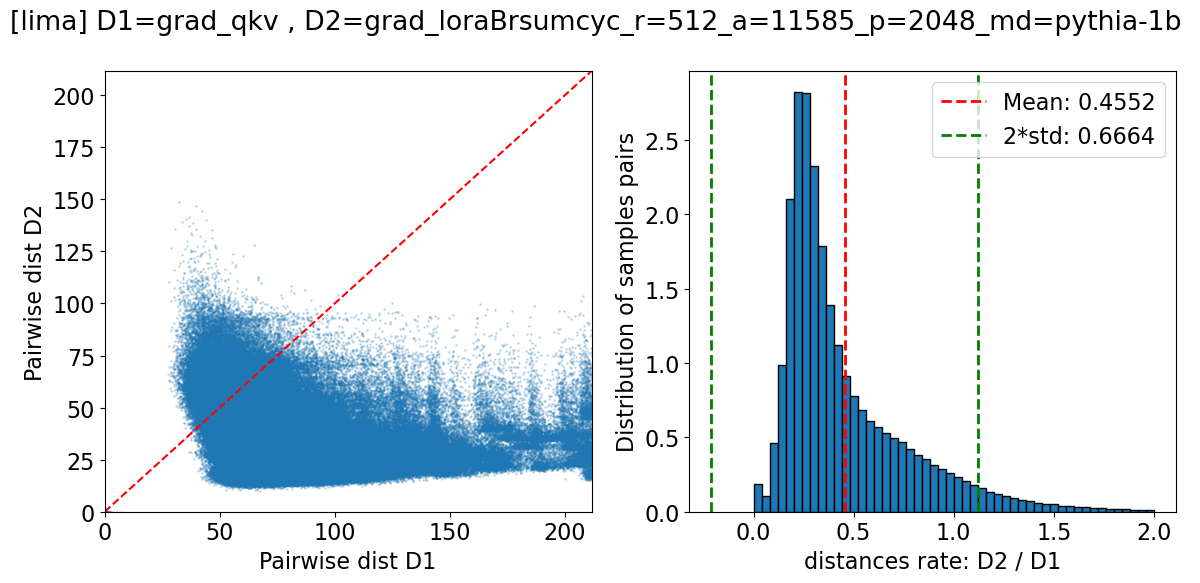

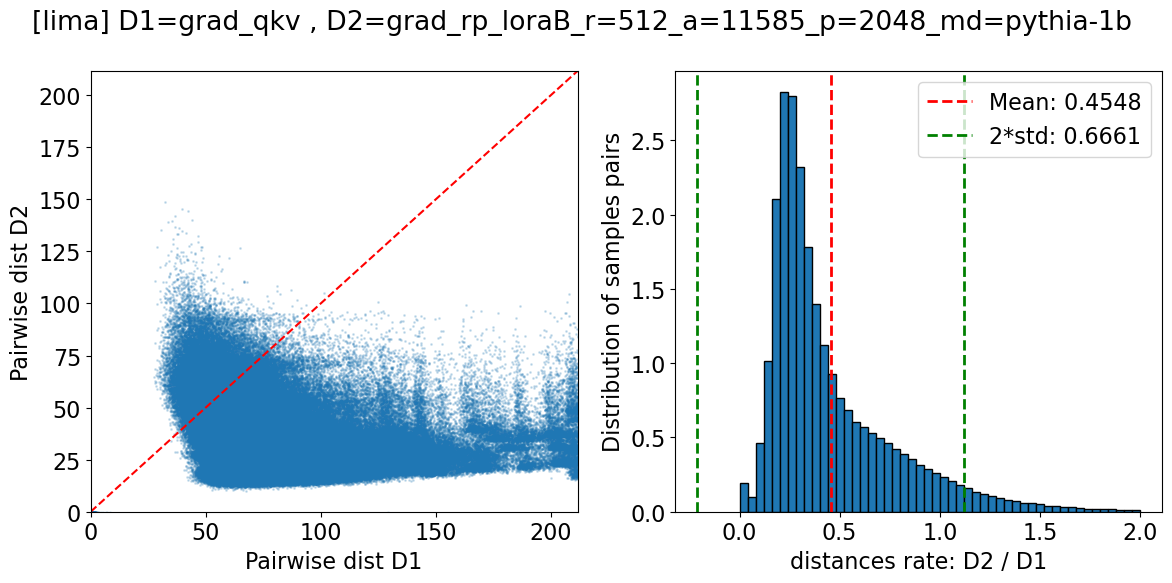

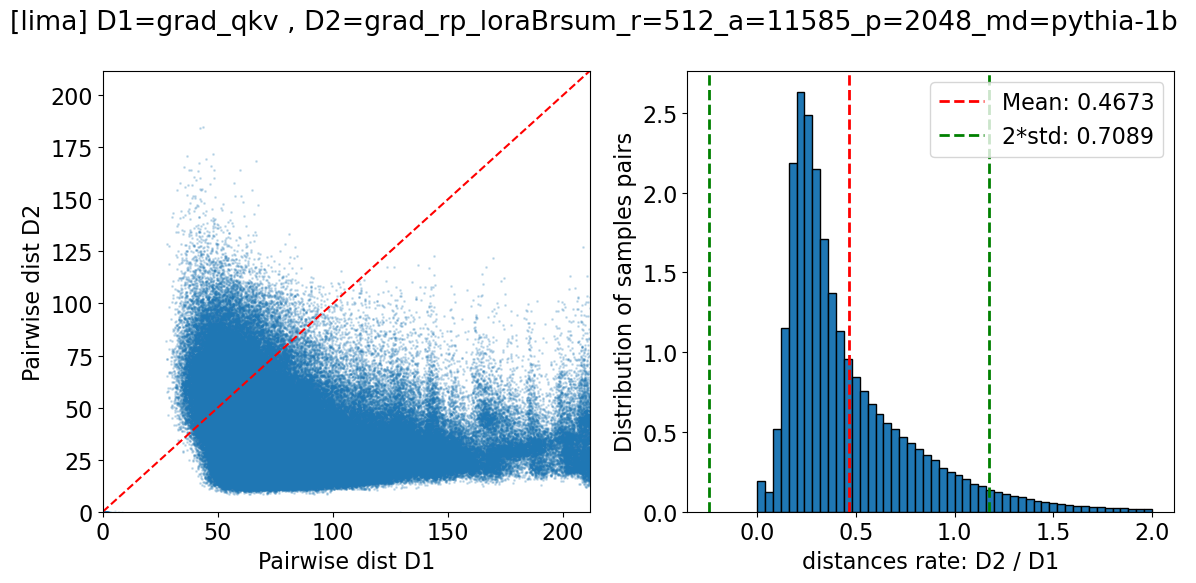

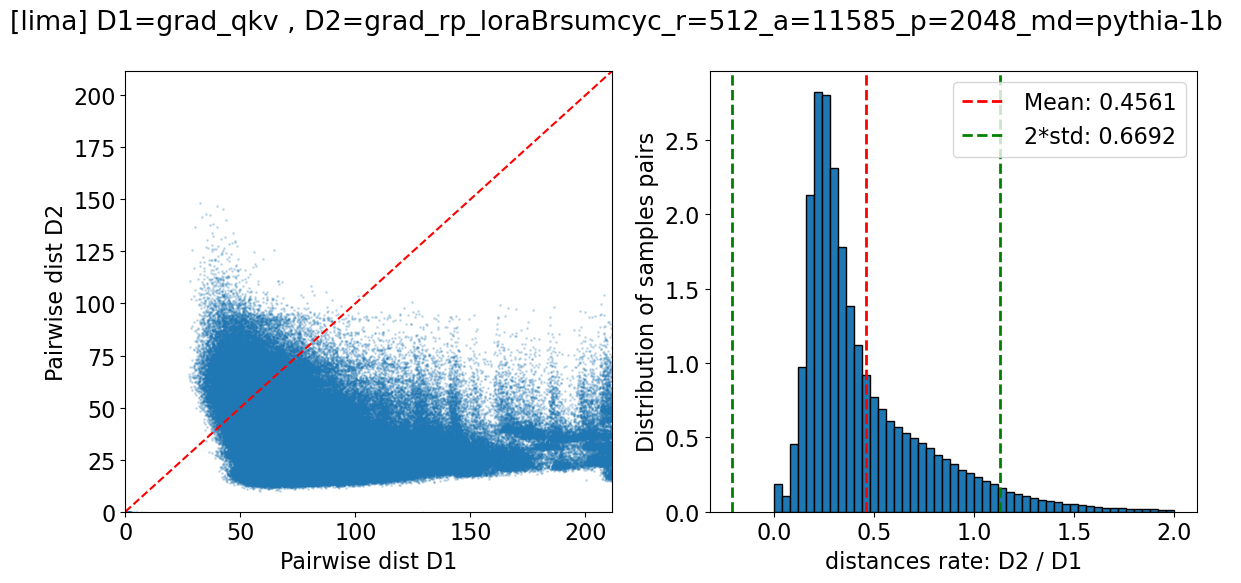

In [13]:
from note_llama_embeddings import get_grad_vectors_cdist, plt_pair_of_dists



# 0.333063 vs. 0.334591

filter_key_fn = lambda k: 'pythia-1b' in k
for k in sorted(list(Ds.keys())):
    if not filter_key_fn(k): continue
    if k == 'grad_qkv':
        continue
    fig, axs = plt_pair_of_dists(Ds['grad_qkv'], Ds[k], use_hexbin=False)
    fig.suptitle(f"[{dataset}] D1=grad_qkv, D2={k} ")
    fig.tight_layout()